# Dark Current Estimation

This noteboook calculates the dark current in a data set

In [368]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy.stats import sigmaclip

## Load Nirc2 Data

In [369]:
# Given array file_number_range in path, this function returns array of data with number label within file_number_range
def get_data(path, file_number_range):
    nirc2_datas = []
    for i in file_number_range:
        nirc2_path_value = path+'n'+(4-len(str(value)))*'0'+f'{i}.fits.gz'
        nirc2_image_value = fits.open(nirc2_path_value)
        nirc2_data_value = nirc2_image_value[0].data
        nirc2_datas.append(nirc2_data_value)
    return nirc2_datas

# Load hdul of given file number, which can be later used to load individual data or headers
def get_hdul(path, file_number):
    nirc2_path_value = path+'n'+(4-len(str(value)))*'0'+f'{file_number}.fits.gz'
    nirc2_image_value = fits.open(nirc2_path_value)
    return nirc2_image_value[0]

## Statistics and Fitting functions

In [370]:
# Outputs averaged image and variance of each pixel of a dataset
def image_processing(signal):
    image_avg = np.average(signal, axis=0)
    image_std = np.std(signal, axis=0)
    return image_avg, image_std

# Outputs average & median signal value and variance of image
def processing(signal):
    data_med = np.median(signal)
    data_avg = np.average(signal)
    data_std = np.std(signal)
    return data_med, data_avg, data_std

# Takes integration time, averaged signal of that integration time, and does polyfit to calculate dark signal per second integration per pixel
def trend_poly(t_int, signal_int, degree):
    fit = np.polyfit(t_int, signal_int, degree)
    dark_poly = np.polyval(fit, t_int)
    return dark_poly, fit

# Statistics with masking. This function masks values that are 5 std (calculated before masking for conservative masking) away.
def masked_processing(signal):
    image_nomask = image_processing(signal)[0]
    image_mask, lower, upper = sigmaclip(image_nomask, low=4.0, high=4.0)
    med_mask = np.median(image_mask)
    avg_mask = image_mask.mean()
    std_mask = image_mask.var()
    return med_mask, avg_mask, std_mask

## Calculate Dark Current
We first separately load data sets with different exposure times. Then we will plot the median dark signal of each averaged data set vs total exposure time (int time x coadd #) for polynomial fitting. Then we will calculate dark signal per 1s exposure time.

### Load all dark data and find average image of each set

In [371]:
path = '2016jul14/'
# File numbers of data we would like to load
value_init_0 = 21 #starting value for data
value_end_0 = 30 #end value
values_0 = np.arange(value_init_0, value_end_0+1)
value_init_1 = 31 #starting value for data
value_end_1 = 40 #end value
values_1 = np.arange(value_init_1, value_end_1+1)
value_init_2 = 41 #starting value for data
value_end_2 = 50 #end value
values_2 = np.arange(value_init_2, value_end_2+1)
value_init_3 = 61 #starting value for data
value_end_3 = 70 #end value
values_3 = np.arange(value_init_3, value_end_3+1)

t_int_0 = get_hdul(path, value_init_0).header['ITIME']
t_int_1 = get_hdul(path, value_init_1).header['ITIME']
t_int_2 = get_hdul(path, value_init_2).header['ITIME']
t_int_3 = get_hdul(path, value_init_3).header['ITIME']
coadd_0 = get_hdul(path, value_init_0).header['COADDS']
coadd_1 = get_hdul(path, value_init_1).header['COADDS']
coadd_2 = get_hdul(path, value_init_2).header['COADDS']
coadd_3 = get_hdul(path, value_init_3).header['COADDS']
gain_0 = get_hdul(path, value_init_0).header['GAIN']
gain_1 = get_hdul(path, value_init_1).header['GAIN']
gain_2 = get_hdul(path, value_init_2).header['GAIN']
gain_3 = get_hdul(path, value_init_3).header['GAIN']

nirc2_datas_0 = get_data(path, values_0)
nirc2_datas_1 = get_data(path, values_1)
nirc2_datas_2 = get_data(path, values_2)
nirc2_datas_3 = get_data(path, values_3)

med_0, avg_0, std_0 = masked_processing(nirc2_datas_0)
med_1, avg_1, std_1 = masked_processing(nirc2_datas_1)
med_2, avg_2, std_2 = masked_processing(nirc2_datas_2)
med_3, avg_3, std_3 = masked_processing(nirc2_datas_3)


print('For data set 0 with file number 21 - 30, median is '+str(med_1)+', average is '+str(avg_1)+', and standard deviation is '+str(std_0))

dark_current_arr = np.array([med_0*gain_0/coadd_0, med_1*gain_1/coadd_1, med_2*gain_2/coadd_2, med_3*gain_3/coadd_3])
dark_std = np.array([std_0*gain_0/coadd_0, std_1*gain_1/coadd_1, std_2*gain_2/coadd_2, std_3*gain_3/coadd_3])
t_int_arr = np.array([t_int_0, t_int_1, t_int_2, t_int_3])

For data set 0 with file number 21 - 30, median is 5.5, average is 5.498617428707243, and standard deviation is 25.629286644261995


### Plot polynomial trend of coadd reduced data w.r.t. integration time

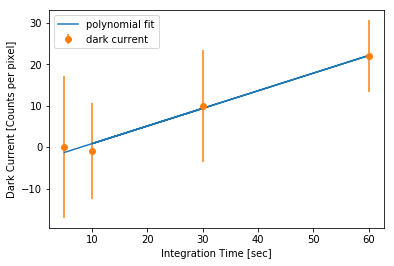

In [373]:
dark_fit_func, fit_coeff = trend_poly(t_int_arr, dark_current_arr, 1)

plt.figure()
plt.plot(t_int, dark_fit_func, label='polynomial fit')
plt.errorbar(t_int, dark_current_arr, yerr = dark_std, fmt='o', label='dark current')
plt.xlabel('Integration Time [sec]')
plt.ylabel('Dark Current [Counts per pixel]')
plt.legend(loc = 'upper left')
plt.show()

## Final Result

In [374]:
print('Dark Current: '+str(fit_coeff[0])+' electrons per pixel per second')

Dark Current: 0.4255072463768117 electrons per pixel per second
